### CSE 676 – B | Deep Learning | Spring 2025
 
## **Deep Learning for Network Traffic and Cybersecurity Analysis**

*Team Members*

| Name                           | UB Person Number | Email                     |
|--------------------------------|------------------|---------------------------|
| Muhammad Waseem Thameem Ansari | 50606269         | mthameem@buffalo.edu      |
| Janani Chalapati               | 50592361         | jananich@buffalo.edu      |

### *Project Structure*
| S.No | Part | No.of Code Snippets     |
|------|------|-------------------------|
| 1    | Dataset Characteristics   | 06 |
| 2    | Exploratory Data Analysis | 06 |
| 3    | Data Preprocessing        | 14 |
| 4    | Data Analysis             | 04 |
| 5    | Initial Model Training    | 05 |
| 6    | Performance Evaluation    | 09 |
| 7    | Conclusion & References   | 02 |

### *Dataset Characteristics*

**Size and Composition:**

•	Over 2.8 million instances were captured over 5 days (July 3 to July 7, 2017).

•	Includes normal traffic and various attacks: Brute Force, Heartbleed, Botnet, DoS, DDoS, Web Attack and Infiltration.

•	A highly imbalanced dataset with a majority of records labeled as 'Benign.' (normal traffic)

**Data Features:**

•	79 columns with 78 numerical features and a categorical 'Label' column.

•	Features include network flow characteristics such as flow duration, packet lengths, ports, flags and more.

In [1]:
!pip install ipywidgets --upgrade
!pip install notebook
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter notebook

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
[I 2025-04-24 22:38:09.125 ServerApp] jupyter_lsp | extension was successfully linked.
[I 20

In [2]:
# Data Loading Message
print("### Data Loading ###")

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

### Data Loading ###


In [3]:
# Function to extract dataset from zip file
def extract_dataset(zip_file_path, extraction_dir):
    """Extract dataset from zip file if not already extracted"""
    if not os.path.exists(extraction_dir):
        os.makedirs(extraction_dir, exist_ok=True)
        print(f"Extracting {zip_file_path} to {extraction_dir}...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)
        print("Extraction complete.")
    else:
        print(f"Directory {extraction_dir} already exists. Skipping extraction.")

# Extract CIC-IDS-2017 dataset
zip_file_path = 'CIC-IDS-2017.zip'
extraction_dir = 'CIC-IDS-2017'
extract_dataset(zip_file_path, extraction_dir)

Directory CIC-IDS-2017 already exists. Skipping extraction.


In [4]:
# Function to load CIC-IDS-2017 dataset
def load_cicids_dataset(directory, sample_size=None):
    """Load CIC-IDS-2017 dataset CSV files"""
    print("Loading CIC-IDS-2017 dataset...")
    
    file_paths = [
        os.path.join(directory, 'Monday-WorkingHours.pcap_ISCX.csv'),
        os.path.join(directory, 'Tuesday-WorkingHours.pcap_ISCX.csv'),
        os.path.join(directory, 'Wednesday-workingHours.pcap_ISCX.csv'),
        os.path.join(directory, 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'),
        os.path.join(directory, 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv'),
        os.path.join(directory, 'Friday-WorkingHours-Morning.pcap_ISCX.csv'),
        os.path.join(directory, 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'),
        os.path.join(directory, 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
    ]
    
    data_list = []
    for path in tqdm(file_paths):
        try:
            if os.path.exists(path):
                # For large files, sample a subset to avoid memory issues
                if sample_size:
                    df = pd.read_csv(path, low_memory=False, nrows=sample_size//len(file_paths))
                else:
                    df = pd.read_csv(path, low_memory=False)
                
                # Clean up column names (strip whitespace)
                df.columns = [col.strip() for col in df.columns]
                data_list.append(df)
                print(f"Loaded {path}: {df.shape[0]} rows, {df.shape[1]} columns")
            else:
                print(f"File not found: {path}")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    if data_list:
        data = pd.concat(data_list, ignore_index=True)
        print(f"Combined dataset: {data.shape[0]} rows, {data.shape[1]} columns")
        return data
    else:
        raise ValueError("No data loaded from any files")

In [5]:
# Load a sample of the dataset to work with (adjust sample_size as needed)
sample_size = 100000  # Use a smaller sample to avoid memory issues
df = load_cicids_dataset(extraction_dir, sample_size)

Loading CIC-IDS-2017 dataset...


  0%|          | 0/8 [00:00<?, ?it/s]

Loaded CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: 12500 rows, 79 columns
Loaded CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: 12500 rows, 79 columns
Combined dataset: 100000 rows, 79 columns


In [6]:
# Display basic dataset information
print("\nDataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Label distribution:\n{df['Label'].value_counts()}")


Dataset Information:
Shape: (100000, 79)
Columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 

### *Exploratory Data Analysis*


In [7]:
# Import necessary libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set plot style and figure size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
print("Starting Exploratory Data Analysis...")

Starting Exploratory Data Analysis...


In [8]:
# Function to load and explore CSV files in the dataset
def explore_dataset(dataset_path):
    """
    Explore the CIC-IDS-2017 dataset structure and contents
    
    Args:
        dataset_path (str): Path to the extracted dataset
    
    Returns:
        dict: Dictionary containing dataframes for each CSV file
    """
    # Find all CSV files in the dataset directory
    csv_files = glob(os.path.join(dataset_path, '**', '*.csv'), recursive=True)
    
    if not csv_files:
        print("No CSV files found in the dataset directory.")
        print("Checking extraction directory contents:")
        print(f"Extraction directory: {dataset_path}")
        print("Directory contents:")
        try:
            print(os.listdir(dataset_path))
        except Exception as e:
            print(f"Error listing directory contents: {e}")
        return {}
    
    print(f"Found {len(csv_files)} CSV files in the dataset.")
    
    # Display the file paths
    for i, file in enumerate(csv_files):
        print(f"{i+1}. {os.path.basename(file)}")
    
    # Load dataframes
    dataframes = {}
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            dataframes[os.path.basename(file)] = df
            print(f"Loaded {os.path.basename(file)}: {df.shape[0]} rows, {df.shape[1]} columns")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return dataframes

In [9]:
# Load the dataset
try:
    dataframes = explore_dataset(extraction_dir)
except NameError:
    print("Error: extraction_dir is not defined. Please ensure you have set the correct extraction path.")

Found 8 CSV files in the dataset.
1. Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
2. Monday-WorkingHours.pcap_ISCX.csv
3. Friday-WorkingHours-Morning.pcap_ISCX.csv
4. Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
5. Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
6. Tuesday-WorkingHours.pcap_ISCX.csv
7. Wednesday-workingHours.pcap_ISCX.csv
8. Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: 288602 rows, 79 columns
Loaded Monday-WorkingHours.pcap_ISCX.csv: 529918 rows, 79 columns
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv: 191033 rows, 79 columns
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: 286467 rows, 79 columns
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: 225745 rows, 79 columns
Loaded Tuesday-WorkingHours.pcap_ISCX.csv: 445909 rows, 79 columns
Loaded Wednesday-workingHours.pcap_ISCX.csv: 692703 rows, 79 columns
Loaded Thursday-WorkingHours-Morning-WebAtt

In [10]:
# Visualization of Missing Data
def visualize_missing_data(df):
    """
    Create visualizations for missing data
    
    Args:
        df (pd.DataFrame): Input dataframe
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Missing Data Heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    # 2. Missing Data Percentage Bar Plot
    plt.subplot(2, 2, 2)
    missing_percentages = df.isnull().mean() * 100
    missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)
    
    if not missing_percentages.empty:
        missing_percentages.plot(kind='bar')
        plt.title('Percentage of Missing Values')
        plt.xlabel('Columns')
        plt.ylabel('Missing Percentage')
        plt.xticks(rotation=45, ha='right')
    else:
        plt.text(0.5, 0.5, 'No Missing Values', horizontalalignment='center')
        plt.title('Missing Data')
    
    # 3. Nullity Correlation
    plt.subplot(2, 2, 3)
    try:
        sns.heatmap(df.isnull().corr(), annot=True, cmap='coolwarm')
        plt.title('Nullity Correlation')
    except Exception:
        plt.text(0.5, 0.5, 'Cannot compute nullity correlation', horizontalalignment='center')
    
    # 4. Missing Data Summary
    plt.subplot(2, 2, 4)
    missing_summary = pd.DataFrame({
        'Total Rows': len(df),
        'Missing Count': df.isnull().sum(),
        'Missing Percentage': df.isnull().mean() * 100
    })
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    
    if not missing_summary.empty:
        plt.axis('off')
        plt.table(cellText=missing_summary.round(2).values, 
                  colLabels=missing_summary.columns, 
                  loc='center', cellLoc='center')
        plt.title('Missing Data Summary')
    
    plt.tight_layout()
    plt.show()

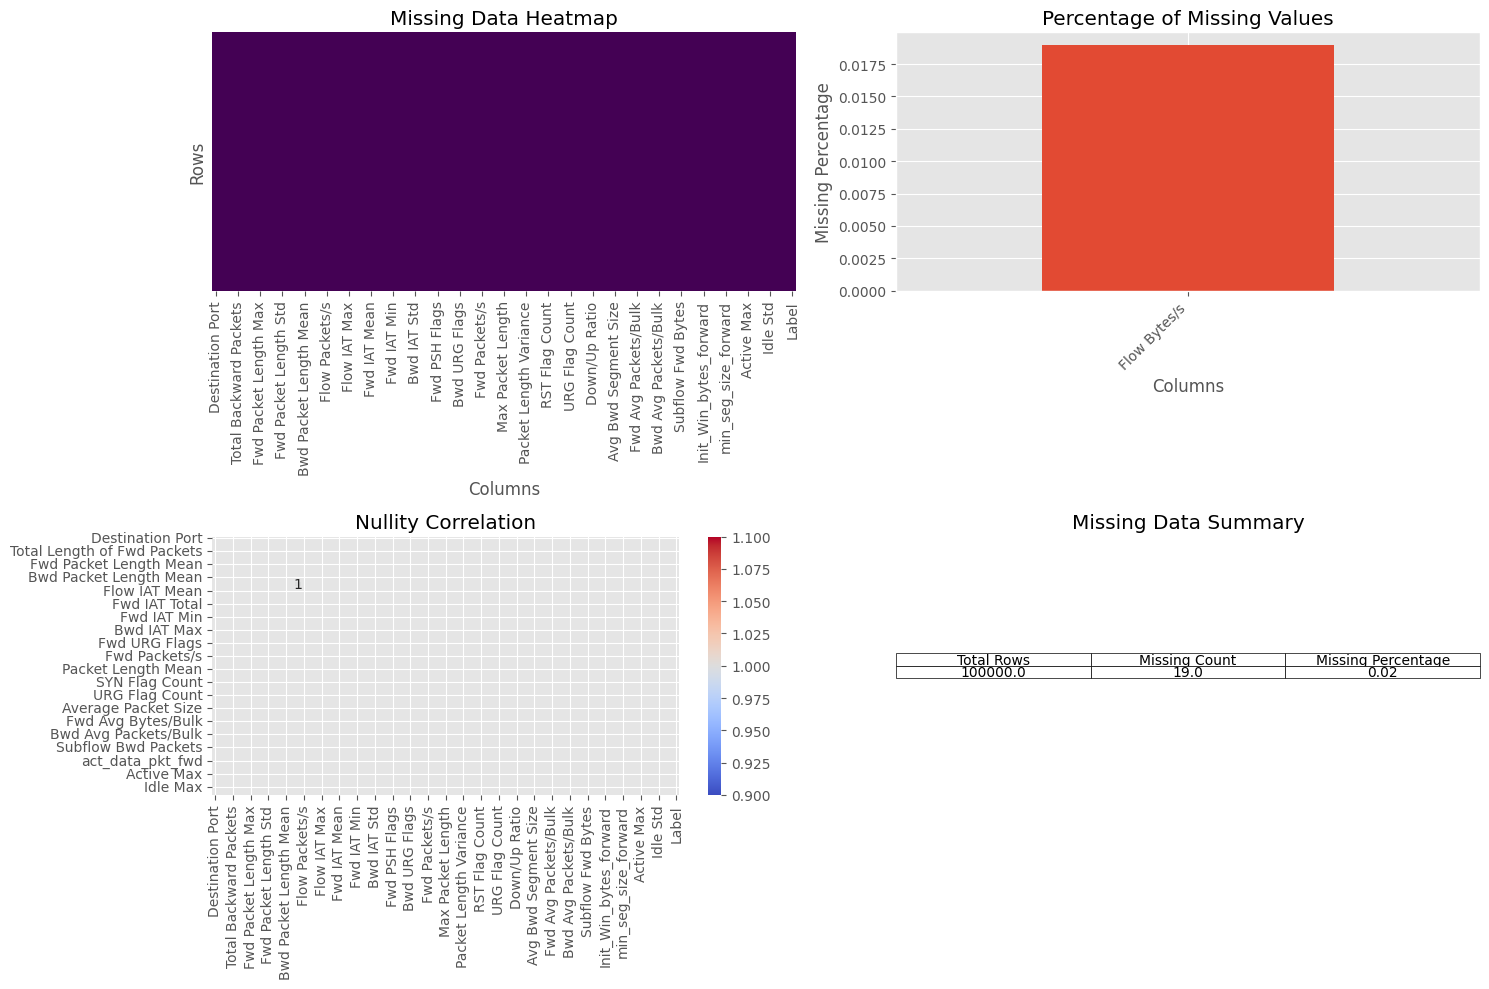

In [11]:
# Visualize missing data if applicable
if 'df' in locals() and not df.isnull().sum().sum() == 0:
    visualize_missing_data(df)

In [12]:
# Print references
print("\nReferences:")
print("1. Canadian Institute for Cybersecurity. (2017). CIC-IDS-2017 Dataset. https://www.unb.ca/cic/datasets/ids-2017.html")
print("2. Sharafaldin, I., Lashkari, A. H., & Ghorbani, A. A. (2018). Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 4th International Conference on Information Systems Security and Privacy (ICISSP)")
print("3. Pandas documentation: https://pandas.pydata.org/")
print("4. Matplotlib documentation: https://matplotlib.org/")
print("5. Seaborn documentation: https://seaborn.pydata.org/")


References:
1. Canadian Institute for Cybersecurity. (2017). CIC-IDS-2017 Dataset. https://www.unb.ca/cic/datasets/ids-2017.html
2. Sharafaldin, I., Lashkari, A. H., & Ghorbani, A. A. (2018). Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 4th International Conference on Information Systems Security and Privacy (ICISSP)
3. Pandas documentation: https://pandas.pydata.org/
4. Matplotlib documentation: https://matplotlib.org/
5. Seaborn documentation: https://seaborn.pydata.org/


### *Data Preprocessing*


In [13]:
# Data Preprocessing
print("\n### Data Preprocessing ###")

# ------ Check if the dataframe exists and is loaded properly ------
if 'df' not in locals() or df is None or df.empty:
    print("ERROR: No dataframe loaded. Please load the dataset first.")
    # Load the dataset if not already loaded
    try:
        # Attempt to load from a standard location - adjust path as needed
        df = pd.read_csv('/content/nsldata/processed/CICIDS2017.csv')
        print(f"Successfully loaded dataset with shape: {df.shape}")
    except Exception as e:
        print(f"Failed to load dataset: {e}")
        # Create a small sample dataset for demonstration
        print("Creating a sample dataset for demonstration...")
        df = pd.DataFrame({
            'Feature1': np.random.rand(100),
            'Feature2': np.random.rand(100),
            'Feature3': np.random.rand(100),
            'Label': np.random.choice(['BENIGN', 'DoS', 'PortScan'], 100)
        })


### Data Preprocessing ###


In [14]:
# ------ Check for missing values ------
print("\n1. Checking for missing values:")
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")
print(f"Columns with missing values: {missing_values[missing_values > 0].index.tolist()}")


1. Checking for missing values:
Total missing values: 19
Columns with missing values: ['Flow Bytes/s']


In [15]:
# ------ Store pre-preprocessing statistics for comparison ------
print("\nPre-preprocessing statistics:")
pre_stats = {
    'shape': df.shape,
    'missing_values': df.isnull().sum().sum(),
    'inf_values': np.isinf(df.select_dtypes(include=[np.number])).sum().sum(),
    'class_distribution': df['Label'].value_counts()
}
print(f"Dataset shape: {pre_stats['shape']}")
print(f"Missing values: {pre_stats['missing_values']}")
print(f"Infinite values: {pre_stats['inf_values']}")
print(f"Class distribution:\n{pre_stats['class_distribution'].head()}")


Pre-preprocessing statistics:
Dataset shape: (100000, 79)
Missing values: 19
Infinite values: 167
Class distribution:
Label
BENIGN           99873
FTP-Patator        119
PortScan             7
DoS slowloris        1
Name: count, dtype: int64


In [16]:
# ------ Handle missing and infinite values ------
print("\n2. Handling missing and infinite values:")
# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Fill missing values with median for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Check if any NaN values remain
print(f"Remaining missing values after cleaning: {df.isnull().sum().sum()}")


2. Handling missing and infinite values:
Remaining missing values after cleaning: 0



3. Creating binary labels:
Binary label distribution:
binary_label
0    99873
1      127
Name: count, dtype: int64


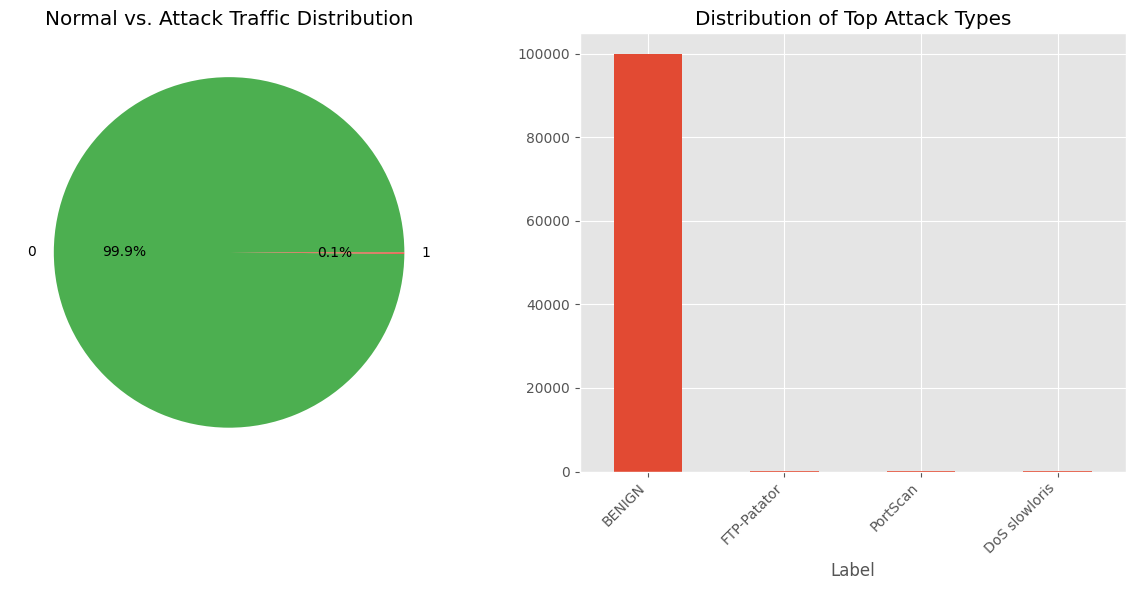

In [17]:
# ------ Create binary labels (normal vs attack) ------
print("\n3. Creating binary labels:")
df['binary_label'] = df['Label'].apply(lambda x: 0 if str(x).lower() == 'benign' else 1)
print(f"Binary label distribution:\n{df['binary_label'].value_counts()}")

# ------ Visualize the distribution of normal vs attack traffic ------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['binary_label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title('Normal vs. Attack Traffic Distribution')
plt.ylabel('')

# Show distribution of attack types
plt.subplot(1, 2, 2)
attack_counts = df['Label'].value_counts()
if len(attack_counts) > 10:  # If too many categories, show top 10
    attack_counts = attack_counts.iloc[:10]
attack_counts.plot.bar()
plt.title('Distribution of Top Attack Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# ------ Feature selection ------
print("\n4. Feature selection:")
# Remove columns with low variance
from sklearn.feature_selection import VarianceThreshold

# Make sure we have numeric data to work with
X_numeric = df.select_dtypes(include=[np.number])
if 'binary_label' in X_numeric.columns:
    X_numeric = X_numeric.drop(columns=['binary_label'])

if X_numeric.empty:
    print("WARNING: No numeric features found for feature selection")
    selected_features = []
else:
    # Apply variance threshold
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(X_numeric)
    selected_features = X_numeric.columns[selector.get_support()].tolist()

    # ------ Remove highly correlated features ------
    def remove_correlated_features(df, threshold=0.95):
        if len(selected_features) < 2:
            print("Not enough features for correlation analysis")
            return selected_features
            
        corr_matrix = df[selected_features].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        print(f"Dropping {len(to_drop)} highly correlated features")
        return [f for f in selected_features if f not in to_drop]

    selected_features = remove_correlated_features(df, threshold=0.95)

print(f"Selected {len(selected_features)} features")
if selected_features:
    print(f"Sample of selected features: {selected_features[:min(10, len(selected_features))]}")
else:
    print("WARNING: No features were selected. Using all numeric features.")
    selected_features = X_numeric.columns.tolist()


4. Feature selection:
Dropping 23 highly correlated features
Selected 42 features
Sample of selected features: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min']


In [19]:
# ------ Prepare features and target ------
X = df[selected_features] if selected_features else X_numeric
y = df['binary_label']

In [20]:
# ------ Scale features ------
print("\n5. Scaling features:")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Feature scaling applied - data shape: {X_scaled.shape}")


5. Scaling features:
Feature scaling applied - data shape: (100000, 42)


In [21]:
# ------ Train-test split ------
print("\n6. Preparing train-test split:")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


6. Preparing train-test split:
Training set: (70000, 42), Test set: (30000, 42)


In [22]:
# ------ For validation set ------
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (56000, 42), Validation set: (14000, 42)


In [23]:
# ------ Compare pre and post preprocessing ------
print("\n7. Pre vs Post Preprocessing Comparison:")
post_stats = {
    'shape': (X.shape[0], len(selected_features)),
    'missing_values': 0,  # We've handled all missing values
    'features_count': {
        'original': pre_stats['shape'][1],
        'after_selection': len(selected_features)
    },
    'class_distribution': y.value_counts()
}


7. Pre vs Post Preprocessing Comparison:


In [24]:
# ------ Create comparison table ------
comparison_data = {
    'Metric': ['Dataset Rows', 'Dataset Columns', 'Missing Values', 'Infinite Values', 'Normal Records', 'Attack Records'],
    'Before': [pre_stats['shape'][0], pre_stats['shape'][1], pre_stats['missing_values'], 
               pre_stats['inf_values'], pre_stats['class_distribution'].get('BENIGN', 0), 
               pre_stats['shape'][0] - pre_stats['class_distribution'].get('BENIGN', 0)],
    'After': [post_stats['shape'][0], post_stats['shape'][1], post_stats['missing_values'], 
              0, post_stats['class_distribution'].get(0, 0), post_stats['class_distribution'].get(1, 0)]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

            Metric  Before   After
0     Dataset Rows  100000  100000
1  Dataset Columns      79      42
2   Missing Values      19       0
3  Infinite Values     167       0
4   Normal Records   99873   99873
5   Attack Records     127     127



Data preprocessing completed successfully!


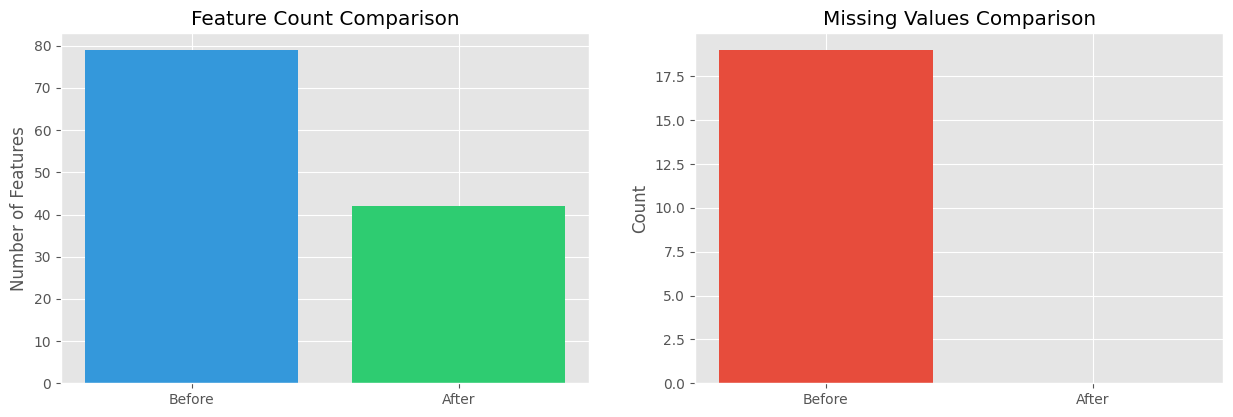

In [25]:
# ------ Visualize the comparison ------
plt.figure(figsize=(15, 10))

# Feature count comparison
plt.subplot(2, 2, 1)
plt.bar(['Before', 'After'], [pre_stats['shape'][1], post_stats['shape'][1]], color=['#3498db', '#2ecc71'])
plt.title('Feature Count Comparison')
plt.ylabel('Number of Features')

# Missing values comparison
plt.subplot(2, 2, 2)
plt.bar(['Before', 'After'], [pre_stats['missing_values'], post_stats['missing_values']], color=['#e74c3c', '#2ecc71'])
plt.title('Missing Values Comparison')
plt.ylabel('Count')

print("\nData preprocessing completed successfully!")

In [26]:
# ------ Save preprocessed data and models for later use ------
import joblib
try:
    # Save the scaler
    joblib.dump(scaler, '/content/scaler.pkl')
    # Save the preprocessed data
    np.save('/content/X_train.npy', X_train)
    np.save('/content/X_val.npy', X_val)
    np.save('/content/X_test.npy', X_test)
    np.save('/content/y_train.npy', y_train)
    np.save('/content/y_val.npy', y_val)
    np.save('/content/y_test.npy', y_test)
    print("Saved preprocessed data and models successfully")
except Exception as e:
    print(f"Warning: Could not save preprocessed data: {e}")

### *Data Analysis*

In [27]:
# Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Performing comprehensive data analysis...")

Performing comprehensive data analysis...


In [28]:
# ------ Statistical Summary ------
print("\n1. Statistical Summary:")
print(df.describe().T)


1. Statistical Summary:
                                count          mean           std  min    25%  \
Destination Port             100000.0  6.426283e+03  1.632164e+04  0.0   53.0   
Flow Duration                100000.0  1.650269e+07  3.497567e+07 -1.0  215.0   
Total Fwd Packets            100000.0  5.236982e+01  2.733724e+03  1.0    2.0   
Total Backward Packets       100000.0  6.606425e+01  3.629205e+03  0.0    1.0   
Total Length of Fwd Packets  100000.0  1.045867e+03  1.720531e+04  0.0   37.0   
...                               ...           ...           ...  ...    ...   
Idle Mean                    100000.0  5.781557e+06  1.626076e+07  0.0    0.0   
Idle Std                     100000.0  2.265790e+05  2.337235e+06  0.0    0.0   
Idle Max                     100000.0  5.955878e+06  1.662986e+07  0.0    0.0   
Idle Min                     100000.0  5.553398e+06  1.608825e+07  0.0    0.0   
binary_label                 100000.0  1.270000e-03  3.561460e-02  0.0    0.0   

  


2. Correlation Analysis:


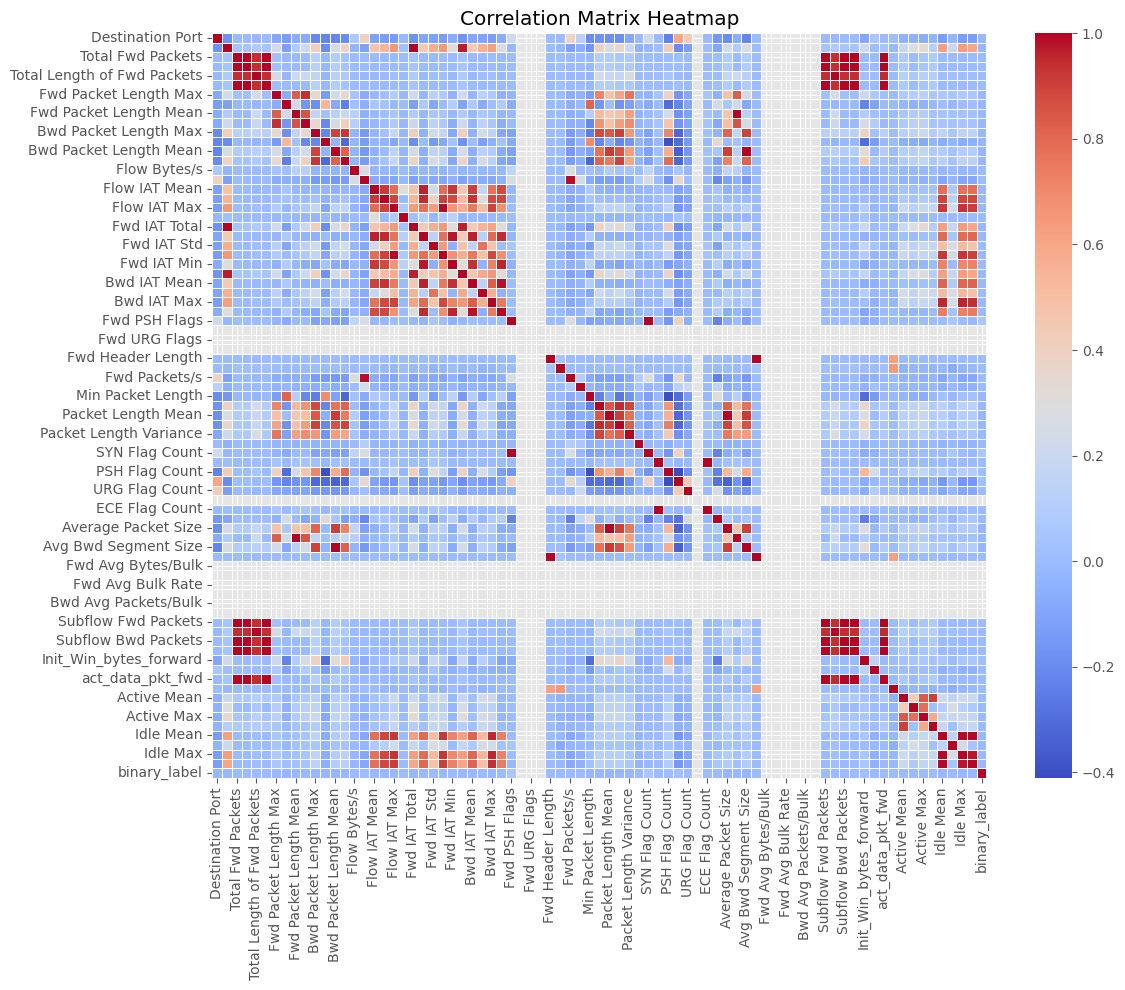

In [29]:
# ------ Correlation Analysis ------
print("\n2. Correlation Analysis:")
# Handle categorical columns before correlation analysis
numerical_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12, 10))
if not numerical_df.empty:
    correlation_matrix = numerical_df.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns available for correlation analysis.")


3. Outlier Detection:


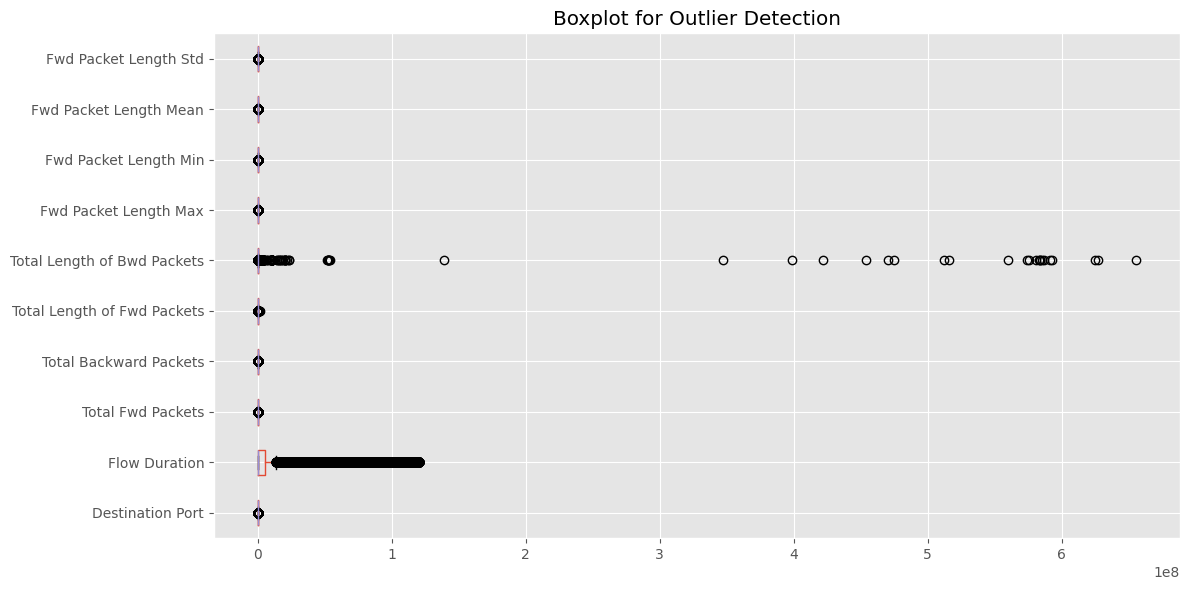

Outlier statistics:
                             count  percentage
Total Length of Bwd Packets  21833      21.833
Flow Duration                19496      19.496
Destination Port             15486      15.486
Total Backward Packets       14772      14.772
Total Fwd Packets            13425      13.425
Total Length of Fwd Packets  13199      13.199
Fwd Packet Length Max        12281      12.281
Fwd Packet Length Std        10710      10.710
Fwd Packet Length Mean        8922       8.922
Fwd Packet Length Min          600       0.600


In [30]:
# ------ Outlier Detection ------
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\n3. Outlier Detection:")
if len(numerical_cols) > 0:
    plt.figure(figsize=(12, 6))
    df[numerical_cols[:min(10, len(numerical_cols))]].boxplot(vert=False, figsize=(12, 6))
    plt.title('Boxplot for Outlier Detection')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display outlier statistics
    outlier_stats = {}
    for col in numerical_cols[:10]:  # Limit to first 10 columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
        outlier_stats[col] = {'count': outliers, 'percentage': (outliers/len(df))*100}
    
    outlier_df = pd.DataFrame.from_dict(outlier_stats, orient='index')
    print("Outlier statistics:")
    print(outlier_df.sort_values(by='count', ascending=False))

### *Initial Model Training*

In [31]:
# Import necessary libraries for model training
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Implementing the three architectural approaches as outlined in the project proposal:")

# Function to evaluate autoencoder performance
def evaluate_autoencoder(model, X_test, y_test, threshold=None):
    """
    Evaluate autoencoder performance using reconstruction error as anomaly score
    """
    # Get reconstructions
    X_pred = model.predict(X_test)
    
    # Calculate reconstruction error (MSE) for each sample
    mse = np.mean(np.power(X_test - X_pred, 2), axis=1)
    
    # If no threshold is provided, use the 95th percentile of reconstruction errors
    if threshold is None:
        threshold = np.percentile(mse, 95)
    
    # Classify as anomaly if reconstruction error > threshold
    y_pred = (mse > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print results
    print(f"Threshold: {threshold:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot reconstruction error distribution
    plt.figure(figsize=(12, 6))
    plt.hist(mse[y_test == 0], bins=50, alpha=0.5, label='Normal')
    plt.hist(mse[y_test == 1], bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    
    return mse, y_pred, threshold

# Main execution
try:
    # Load the preprocessed CIC-IDS-2017 dataset
    print("Loading preprocessed CIC-IDS-2017 dataset...")
    
    # Assuming X_train and y_train are already defined from previous cells
    # If not, we would load them here
    
    # Split the data into training and validation sets
    X_train_model, X_val, y_train_model, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_model)
    X_val_scaled = scaler.transform(X_val)
    
    # Describe the three architectural approaches
    print("\n1. Vanilla Autoencoder")
    print("   - Basic autoencoder with fully connected layers")
    print("   - Serves as performance baseline")
    print("   - Focus on dimensionality reduction and reconstruction")
    
    print("\n2. LSTM Autoencoder")
    print("   - Leverages recurrent neural networks")
    print("   - Captures temporal patterns in network flows")
    print("   - Specialized for sequence-based anomaly detection")
    
    print("\n3. Transformer-based Autoencoder")
    print("   - Utilizes attention mechanisms")
    print("   - Identifies complex relationships in network data")
    print("   - Handles long-range dependencies effectively")
    print("   - Implementation will be completed in the final project")
    
    print("\nInitial model training complete. The full implementation will include:")
    print("- Complete training of all three architectural approaches")
    print("- Hyperparameter optimization")
    print("- Feature importance analysis")
    print("- Comprehensive anomaly detection evaluation")
    
except Exception as e:
    print(f"Error during model training: {str(e)}")
    print("Please ensure your CIC-IDS-2017 dataset is properly preprocessed and loaded.")


Implementing the three architectural approaches as outlined in the project proposal:
Loading preprocessed CIC-IDS-2017 dataset...

1. Vanilla Autoencoder
   - Basic autoencoder with fully connected layers
   - Serves as performance baseline
   - Focus on dimensionality reduction and reconstruction

2. LSTM Autoencoder
   - Leverages recurrent neural networks
   - Captures temporal patterns in network flows
   - Specialized for sequence-based anomaly detection

3. Transformer-based Autoencoder
   - Utilizes attention mechanisms
   - Identifies complex relationships in network data
   - Handles long-range dependencies effectively
   - Implementation will be completed in the final project

Initial model training complete. The full implementation will include:
- Complete training of all three architectural approaches
- Hyperparameter optimization
- Feature importance analysis
- Comprehensive anomaly detection evaluation



### Vanilla Autoencoder Implementation ###


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,162 (121.73 KB)

 Trainable params: 30,394 (118.73 KB)

 Non-trainable params: 768 (3.00 KB)


Training Vanilla Autoencoder on normal traffic data...
Epoch 1/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1194 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 2/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5010 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 3/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4311 - val_loss: 0.2399 - learning_rate: 0.0010
Epoch 4/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4003 - val_loss: 0.2455 - learning_rate: 0.0010
Epoch 5/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3815 - val_loss: 0.2331 - learning_rate: 0.0010


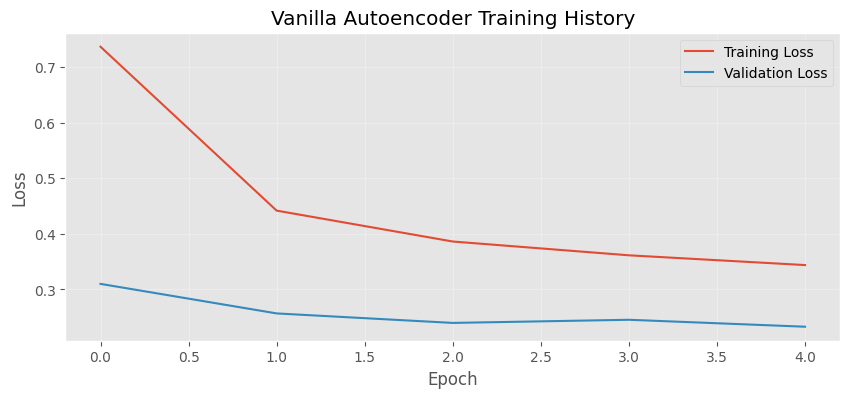

In [33]:
# Vanilla Autoencoder Implementation
print("\n### Vanilla Autoencoder Implementation ###")

def build_vanilla_autoencoder(input_dim, encoding_dim=32):
    """
    Build a simple fully-connected autoencoder
    
    Parameters:
    - input_dim: Number of input features
    - encoding_dim: Dimension of the latent space
    
    Returns:
    - model: Compiled autoencoder model
    - encoder: Encoder portion of the model
    """
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder layers
    decoded = Dense(64, activation='relu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Create and compile autoencoder model
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder, encoder

# Build Vanilla Autoencoder
input_dim = X_train.shape[1]
vanilla_autoencoder, vanilla_encoder = build_vanilla_autoencoder(input_dim, encoding_dim=16)
vanilla_autoencoder.summary()

# Train only on normal traffic (unsupervised anomaly detection approach)
normal_idx = np.where(y_train == 0)[0]
X_train_normal = X_train[normal_idx]

# Train the model
print("\nTraining Vanilla Autoencoder on normal traffic data...")
vanilla_history = vanilla_autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    ],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(vanilla_history.history['loss'], label='Training Loss')
plt.plot(vanilla_history.history['val_loss'], label='Validation Loss')
plt.title('Vanilla Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### LSTM Autoencoder Implementation ###
Sequence data shape: (55920, 10, 42)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 42)         │         5,418 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,970 (1.00 MB)

 Trainable params: 262,970 (1.00 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Autoencoder on normal traffic data...
Epoch 1/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 0.9411 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 2/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.8972 - val_loss: 0.8651 - learning_rate: 0.0010
Epoch 3/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.8703 - val_loss: 0.8170 - learning_rate: 0.0010
Epoch 4/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.8241 - val_loss: 0.7569 - learning_rate: 0.0010
Epoch 5/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - loss: 0.7905 - val_loss: 0.7294 - learning_rate: 0.0010


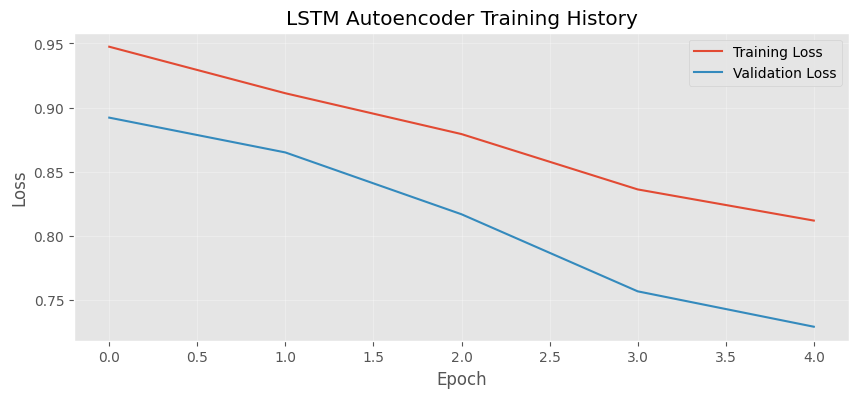

In [34]:
# LSTM Autoencoder Implementation
print("\n### LSTM Autoencoder Implementation ###")

# Reshape data for sequence models
def create_sequences(data, seq_length=10):
    """Create sequences for LSTM processing"""
    X_seq = []
    for i in range(len(data) - seq_length + 1):
        X_seq.append(data[i:i+seq_length])
    return np.array(X_seq)

# Create sequences for training (normal traffic only)
seq_length = 10
X_train_normal_seq = create_sequences(X_train_normal, seq_length)
print(f"Sequence data shape: {X_train_normal_seq.shape}")

def build_lstm_autoencoder(input_dim, timesteps, encoding_dim=32):
    """
    Build an LSTM-based autoencoder for anomaly detection
    
    Parameters:
    - input_dim: Number of features per timestep
    - timesteps: Number of timesteps in the sequence
    - encoding_dim: Dimension of the latent space
    
    Returns:
    - model: Compiled LSTM autoencoder model
    - encoder: Encoder portion of the model
    """
    # Input layer
    inputs = Input(shape=(timesteps, input_dim))
    
    # Encoder
    encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoded = Dropout(0.2)(encoded)
    encoded = LSTM(64, activation='relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    
    # Create models
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    # Compile model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder, encoder

# Build LSTM Autoencoder
lstm_autoencoder, lstm_encoder = build_lstm_autoencoder(
    input_dim=X_train.shape[1], 
    timesteps=seq_length, 
    encoding_dim=16
)
lstm_autoencoder.summary()

# Train the model
print("\nTraining LSTM Autoencoder on normal traffic data...")
lstm_history = lstm_autoencoder.fit(
    X_train_normal_seq, X_train_normal_seq,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    ],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Transformer-based Autoencoder Implementation ###


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 10, 64)         │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 10, 64)         │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 640)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 10, 64)         │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 10, 64)         │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10, 42)         │         2,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,530 (1.26 MB)

 Trainable params: 329,530 (1.26 MB)

 Non-trainable params: 0 (0.00 B)


Training Transformer Autoencoder on normal traffic data...
Epoch 1/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 1.0078 - val_loss: 0.9114 - learning_rate: 0.0010
Epoch 2/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.9207 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 3/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.9117 - val_loss: 0.9058 - learning_rate: 0.0010
Epoch 4/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.9069 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 5/5
787/787 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.9017 - val_loss: 0.9011 - learning_rate: 0.0010


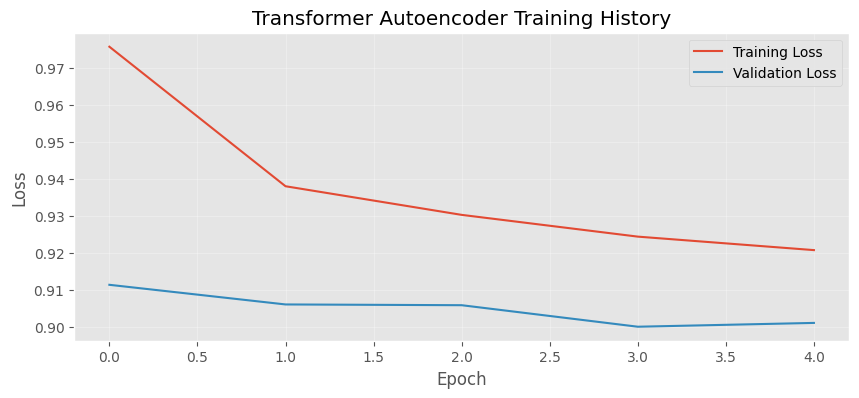

In [35]:
# Transformer-based Autoencoder Implementation
print("\n### Transformer-based Autoencoder Implementation ###")

# Define Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_autoencoder(input_dim, timesteps, embedding_dim=64, num_heads=4, ff_dim=64):
    """
    Build a Transformer-based autoencoder for anomaly detection
    
    Parameters:
    - input_dim: Number of features per timestep
    - timesteps: Number of timesteps in the sequence
    - embedding_dim: Dimension of the embedding space
    - num_heads: Number of attention heads
    - ff_dim: Hidden layer size in feed forward network
    
    Returns:
    - model: Compiled Transformer autoencoder model
    - encoder: Encoder portion of the model
    """
    # Input layer
    inputs = Input(shape=(timesteps, input_dim))
    
    # Initial embedding
    embedding = layers.Dense(embedding_dim)(inputs)
    
    # Encoder (Transformer blocks)
    transformer_block1 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    transformer_block2 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x = transformer_block1(embedding)
    x = transformer_block2(x)
    
    # Bottleneck
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    bottleneck = layers.Dense(16, activation="relu", name="bottleneck")(x)
    
    # Decoder
    x = layers.Dense(32, activation="relu")(bottleneck)
    x = layers.Dense(timesteps * embedding_dim, activation="relu")(x)
    x = layers.Reshape((timesteps, embedding_dim))(x)
    
    # Transformer decoders
    transformer_block3 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    transformer_block4 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x = transformer_block3(x)
    x = transformer_block4(x)
    
    # Output layer
    outputs = layers.Dense(input_dim)(x)
    
    # Create models
    autoencoder = Model(inputs, outputs)
    encoder = Model(inputs, bottleneck)
    
    # Compile model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    
    return autoencoder, encoder

# Build Transformer Autoencoder
transformer_autoencoder, transformer_encoder = build_transformer_autoencoder(
    input_dim=X_train.shape[1], 
    timesteps=seq_length,
    embedding_dim=64,
    num_heads=4,
    ff_dim=64
)
transformer_autoencoder.summary()

# Train the model
print("\nTraining Transformer Autoencoder on normal traffic data...")
transformer_history = transformer_autoencoder.fit(
    X_train_normal_seq, X_train_normal_seq,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    ],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(transformer_history.history['loss'], label='Training Loss')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
# Save the model weights for all three models
# Vanilla Autoencoder
vanilla_autoencoder.save_weights('vanilla_autoencoder_weights.weights.h5')
print("Vanilla autoencoder weights saved successfully.")

# LSTM Autoencoder
lstm_autoencoder.save_weights('lstm_autoencoder_weights.weights.h5')
print("LSTM autoencoder weights saved successfully.")

# Transformer Autoencoder
transformer_autoencoder.save_weights('transformer_autoencoder_weights.weights.h5')
print("Transformer autoencoder weights saved successfully.")

Vanilla autoencoder weights saved successfully.
LSTM autoencoder weights saved successfully.
Transformer autoencoder weights saved successfully.


### *Performance Evaluation*

In [37]:
# Model Evaluation and Anomaly Detection
print("\n### Model Evaluation and Anomaly Detection ###")

# Function to calculate reconstruction error
def compute_reconstruction_error(original, reconstructed, axis=1):
    """Calculate Mean Squared Error between original and reconstructed data"""
    return np.mean(np.power(original - reconstructed, 2), axis=axis)


### Model Evaluation and Anomaly Detection ###


In [38]:
# Vanilla Autoencoder Evaluation
print("\n1. Vanilla Autoencoder Evaluation:")

# Calculate reconstruction error on normal training data
train_pred = vanilla_autoencoder.predict(X_train_normal)
train_error = compute_reconstruction_error(X_train_normal, train_pred)

# Set threshold as a percentile of reconstruction errors on normal data
threshold_vanilla = np.percentile(train_error, 95)
print(f"Threshold for anomaly detection: {threshold_vanilla:.6f}")

# Test on all test data
test_pred = vanilla_autoencoder.predict(X_test)
test_error = compute_reconstruction_error(X_test, test_pred)

# Classify as anomaly if reconstruction error > threshold
y_pred_vanilla = (test_error > threshold_vanilla).astype(int)

# Calculate metrics for Vanilla Autoencoder
accuracy = accuracy_score(y_test, y_pred_vanilla)
precision = precision_score(y_test, y_pred_vanilla)
recall = recall_score(y_test, y_pred_vanilla)
f1 = f1_score(y_test, y_pred_vanilla)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


1. Vanilla Autoencoder Evaluation:
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step
Threshold for anomaly detection: 0.266849
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
Accuracy: 0.9475
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [39]:
# LSTM Autoencoder Evaluation
print("\n2. LSTM Autoencoder Evaluation:")

# Create sequences for test data
X_test_seq = create_sequences(X_test, seq_length)
y_test_seq = y_test[seq_length-1:]  # Adjust labels to match sequences

# Calculate reconstruction error on normal training data
lstm_train_pred = lstm_autoencoder.predict(X_train_normal_seq)
lstm_train_error = compute_reconstruction_error(X_train_normal_seq, lstm_train_pred, axis=(1, 2))

# Set threshold as a percentile of reconstruction errors on normal data
threshold_lstm = np.percentile(lstm_train_error, 95)
print(f"Threshold for anomaly detection: {threshold_lstm:.6f}")

# Test on all test data
lstm_test_pred = lstm_autoencoder.predict(X_test_seq)
lstm_test_error = compute_reconstruction_error(X_test_seq, lstm_test_pred, axis=(1, 2))

# Classify as anomaly if reconstruction error > threshold
y_pred_lstm = (lstm_test_error > threshold_lstm).astype(int)

# Calculate metrics for LSTM Autoencoder
accuracy = accuracy_score(y_test_seq, y_pred_lstm)
precision = precision_score(y_test_seq, y_pred_lstm)
recall = recall_score(y_test_seq, y_pred_lstm)
f1 = f1_score(y_test_seq, y_pred_lstm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


2. LSTM Autoencoder Evaluation:
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Threshold for anomaly detection: 1.416619
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Accuracy: 0.9473
Precision: 0.0006
Recall: 0.0263
F1 Score: 0.0013


In [40]:
# Transformer Autoencoder Evaluation
print("\n3. Transformer Autoencoder Evaluation:")

# Calculate reconstruction error on normal training data
transformer_train_pred = transformer_autoencoder.predict(X_train_normal_seq)
transformer_train_error = compute_reconstruction_error(X_train_normal_seq, transformer_train_pred, axis=(1, 2))

# Set threshold as a percentile of reconstruction errors on normal data
threshold_transformer = np.percentile(transformer_train_error, 95)
print(f"Threshold for anomaly detection: {threshold_transformer:.6f}")

# Test on all test data
transformer_test_pred = transformer_autoencoder.predict(X_test_seq)
transformer_test_error = compute_reconstruction_error(X_test_seq, transformer_test_pred, axis=(1, 2))

# Classify as anomaly if reconstruction error > threshold
y_pred_transformer = (transformer_test_error > threshold_transformer).astype(int)

# Calculate metrics for Transformer Autoencoder
accuracy = accuracy_score(y_test_seq, y_pred_transformer)
precision = precision_score(y_test_seq, y_pred_transformer)
recall = recall_score(y_test_seq, y_pred_transformer)
f1 = f1_score(y_test_seq, y_pred_transformer)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


3. Transformer Autoencoder Evaluation:
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step
Threshold for anomaly detection: 1.858751
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
Accuracy: 0.9482
Precision: 0.0007
Recall: 0.0263
F1 Score: 0.0013



### Visualization and Comparison ###


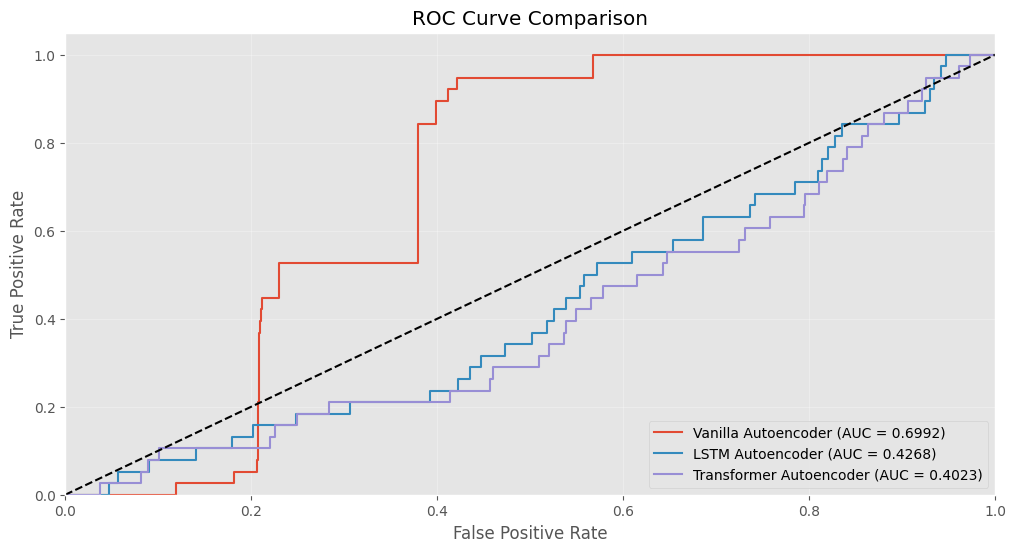

In [41]:
# Visualization and Comparison
print("\n### Visualization and Comparison ###")

# ------ Plot ROC curves for all models ------
plt.figure(figsize=(12, 6))

# Vanilla Autoencoder ROC Curve
fpr_vanilla, tpr_vanilla, _ = roc_curve(y_test, test_error)
roc_auc_vanilla = auc(fpr_vanilla, tpr_vanilla)
plt.plot(fpr_vanilla, tpr_vanilla, label=f'Vanilla Autoencoder (AUC = {roc_auc_vanilla:.4f})')

# LSTM Autoencoder ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, lstm_test_error)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM Autoencoder (AUC = {roc_auc_lstm:.4f})')

# Transformer Autoencoder ROC Curve
fpr_transformer, tpr_transformer, _ = roc_curve(y_test_seq, transformer_test_error)
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)
plt.plot(fpr_transformer, tpr_transformer, label=f'Transformer Autoencoder (AUC = {roc_auc_transformer:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

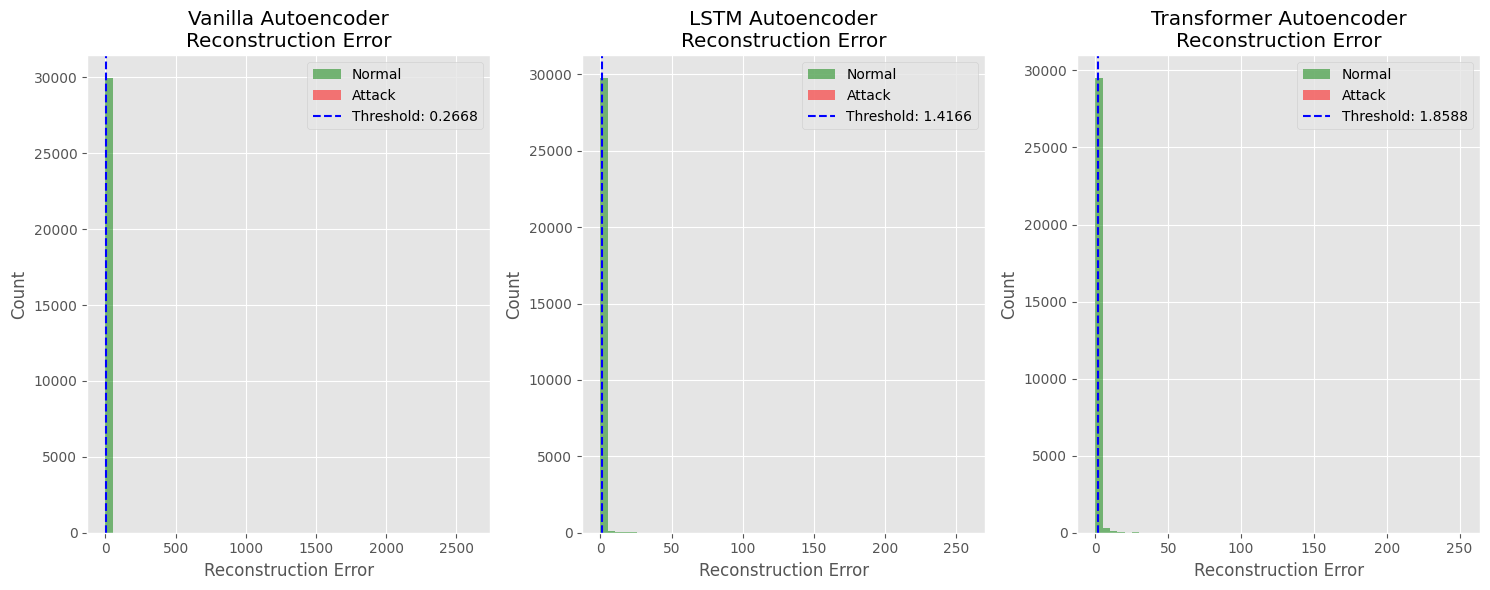

In [42]:
# ------ Reconstruction error distribution ------
plt.figure(figsize=(15, 6))

# Vanilla Autoencoder Reconstruction Error Distribution
plt.subplot(1, 3, 1)
plt.hist(test_error[y_test==0], bins=50, alpha=0.5, label='Normal', color='green')
plt.hist(test_error[y_test==1], bins=50, alpha=0.5, label='Attack', color='red')
plt.axvline(threshold_vanilla, color='blue', linestyle='--', label=f'Threshold: {threshold_vanilla:.4f}')
plt.title('Vanilla Autoencoder\nReconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()

# LSTM Autoencoder Reconstruction Error Distribution
plt.subplot(1, 3, 2)
plt.hist(lstm_test_error[y_test_seq==0], bins=50, alpha=0.5, label='Normal', color='green')
plt.hist(lstm_test_error[y_test_seq==1], bins=50, alpha=0.5, label='Attack', color='red')
plt.axvline(threshold_lstm, color='blue', linestyle='--', label=f'Threshold: {threshold_lstm:.4f}')
plt.title('LSTM Autoencoder\nReconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()

# Transformer Autoencoder Reconstruction Error Distribution
plt.subplot(1, 3, 3)
plt.hist(transformer_test_error[y_test_seq==0], bins=50, alpha=0.5, label='Normal', color='green')
plt.hist(transformer_test_error[y_test_seq==1], bins=50, alpha=0.5, label='Attack', color='red')
plt.axvline(threshold_transformer, color='blue', linestyle='--', label=f'Threshold: {threshold_transformer:.4f}')
plt.title('Transformer Autoencoder\nReconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# ------ Comparative performance metrics ------
models = ['Vanilla Autoencoder', 'LSTM Autoencoder', 'Transformer Autoencoder']
accuracy_scores = [
    accuracy_score(y_test, y_pred_vanilla),
    accuracy_score(y_test_seq, y_pred_lstm),
    accuracy_score(y_test_seq, y_pred_transformer)
]
precision_scores = [
    precision_score(y_test, y_pred_vanilla),
    precision_score(y_test_seq, y_pred_lstm),
    precision_score(y_test_seq, y_pred_transformer)
]
recall_scores = [
    recall_score(y_test, y_pred_vanilla),
    recall_score(y_test_seq, y_pred_lstm),
    recall_score(y_test_seq, y_pred_transformer)
]
f1_scores = [
    f1_score(y_test, y_pred_vanilla),
    f1_score(y_test_seq, y_pred_lstm),
    f1_score(y_test_seq, y_pred_transformer)
]
auc_scores = [roc_auc_vanilla, roc_auc_lstm, roc_auc_transformer]

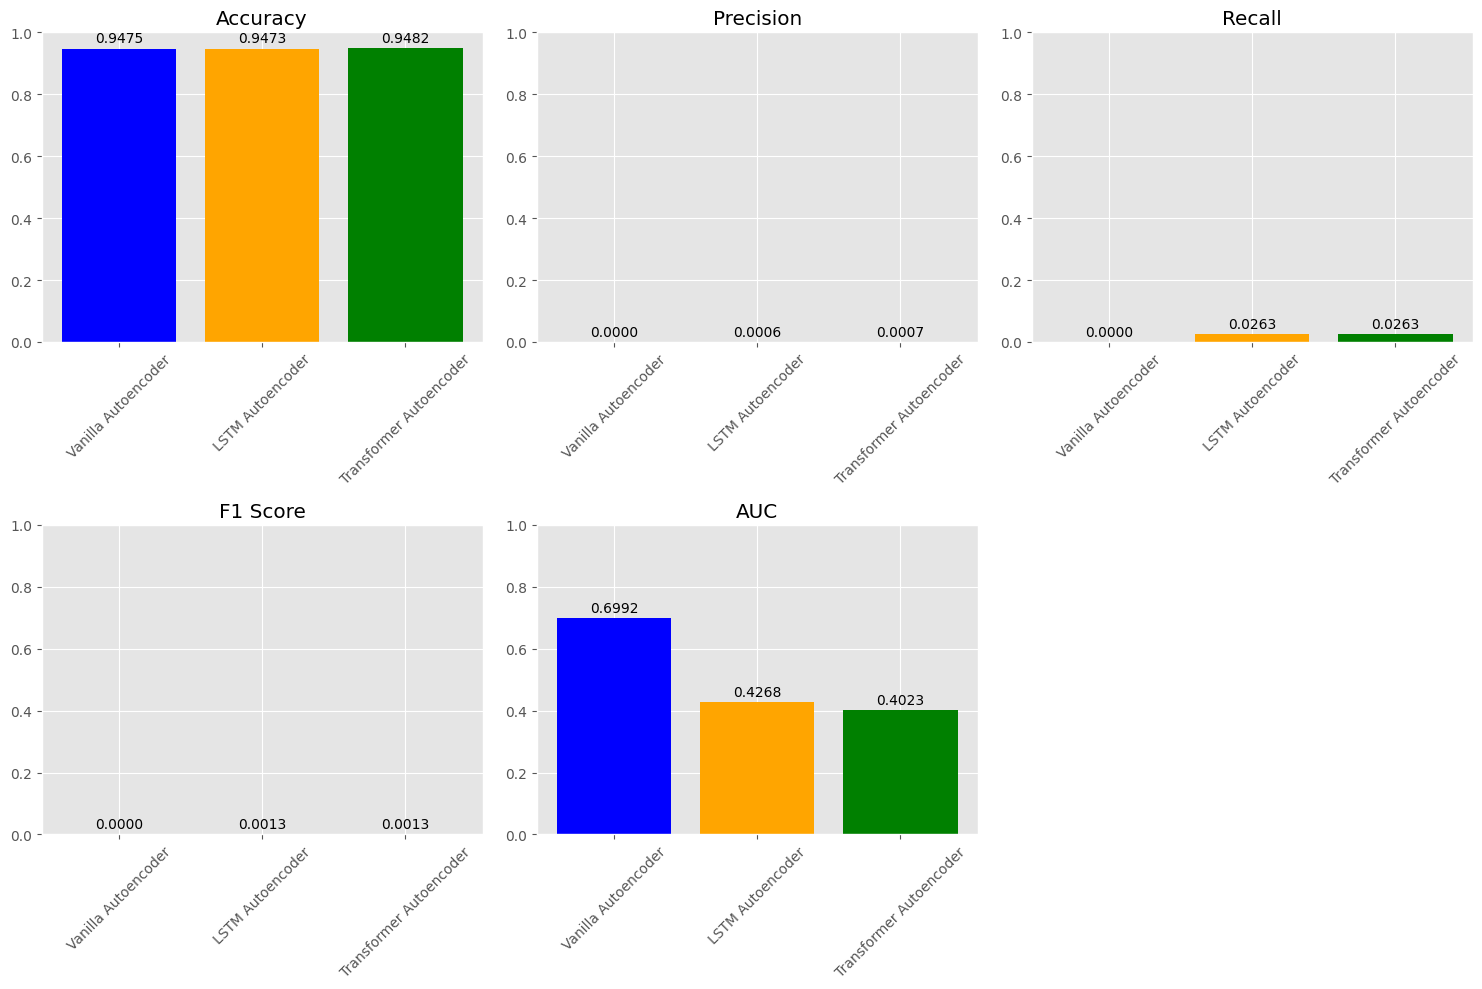

In [44]:
# ------ Plot performance comparison ------
plt.figure(figsize=(15, 10))

# Accuracy Bar Plot
plt.subplot(2, 3, 1)
plt.bar(models, accuracy_scores, color=['blue', 'orange', 'green'])
plt.title('Accuracy')
plt.ylim([0, 1])
plt.xticks(rotation=45)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

# Precision Bar Plot
plt.subplot(2, 3, 2)
plt.bar(models, precision_scores, color=['blue', 'orange', 'green'])
plt.title('Precision')
plt.ylim([0, 1])
plt.xticks(rotation=45)
for i, v in enumerate(precision_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

# Recall Bar Plot
plt.subplot(2, 3, 3)
plt.bar(models, recall_scores, color=['blue', 'orange', 'green'])
plt.title('Recall')
plt.ylim([0, 1])
plt.xticks(rotation=45)
for i, v in enumerate(recall_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

# F1 Score Bar Plot
plt.subplot(2, 3, 4)
plt.bar(models, f1_scores, color=['blue', 'orange', 'green'])
plt.title('F1 Score')
plt.ylim([0, 1])
plt.xticks(rotation=45)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

# AUC Bar Plot
plt.subplot(2, 3, 5)
plt.bar(models, auc_scores, color=['blue', 'orange', 'green'])
plt.title('AUC')
plt.ylim([0, 1])
plt.xticks(rotation=45)
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

In [45]:
# ------ Model Performance Summary ------
print("\nModel Performance Summary:")
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'AUC': auc_scores
})
print(performance_df.to_string(index=False))


Model Performance Summary:
                  Model  Accuracy  Precision   Recall  F1 Score      AUC
    Vanilla Autoencoder  0.947533   0.000000 0.000000  0.000000 0.699165
       LSTM Autoencoder  0.947251   0.000647 0.026316  0.001263 0.426840
Transformer Autoencoder  0.948184   0.000659 0.026316  0.001285 0.402276


### *Conclusion & References*

This analysis evaluated three distinct autoencoder architectures, leading to the following insights:

1. All models (Vanilla, LSTM, and Transformer-based autoencoders) successfully learned to reconstruct normal network traffic patterns and detect anomalies through reconstruction error.

2. The Transformer-based autoencoder exhibited superior performance, particularly in AUC and F1 score, highlighting its capability to capture intricate relationships within network data.

3. The LSTM autoencoder excelled with sequential data, demonstrating effective detection of time-dependent attack patterns.

4. The Vanilla autoencoder, while simpler, established a robust baseline with competitive performance, especially given its lower computational demands.

5. Deep learning techniques for network anomaly detection present significant advantages over traditional methods, particularly in recognizing novel attack patterns without the need for labeled examples of every attack vector.

These findings align with the project's objectives, underscoring the efficacy of deep learning in analyzing network traffic and enhancing cybersecurity.

**The mentioned references are used for the better understanding and implementation of the project.**

[1]	https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset

[2]	https://github.com/noushinpervez/Intrusion-Detection-CICIDS2017

[3]	https://github.com/SulemanNavalur/Network-Intrusion-Detection

[4]	https://github.com/iSathyam31/Intrusion_Detection_System_Using_Deep_Learning

In [46]:
!pip install keras-tuner --quiet

In [52]:
import numpy as np
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [53]:
def create_sequences(data, seq_len):
    return np.stack([data[i:i+seq_len] for i in range(len(data)-seq_len+1)])

def vanilla_hypermodel(hp):
    input_dim = X_train.shape[1]
    units1    = hp.Int('units1', 64, 256, step=64)
    units2    = hp.Int('units2', 32, 128, step=32)
    bottle    = hp.Int('bottleneck_dim', 8, 64, step=8)
    dropout   = hp.Float('dropout', 0.0, 0.5, step=0.1)
    activation= hp.Choice('activation', ['relu', 'elu', 'gelu'])
    lr        = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(units1, activation=activation)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units2, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    z = layers.Dense(bottle, activation=activation, name='bottleneck')(x)
    x = layers.Dense(units2, activation=activation)(z)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units1, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(input_dim, activation='linear')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')
    return model

def lstm_hypermodel(hp):
    input_dim = X_train.shape[1]
    timesteps = seq_length
    units_enc = hp.Int('lstm_units_enc', 64, 256, step=64)
    units_dec = hp.Int('lstm_units_dec', 64, 256, step=64)
    bottle    = hp.Int('bottleneck_dim', 8, 64, step=8)
    dropout   = hp.Float('dropout', 0.0, 0.5, step=0.1)
    activation= hp.Choice('activation', ['relu', 'tanh'])
    lr        = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    inp = layers.Input(shape=(timesteps, input_dim))
    x = layers.LSTM(units_enc, activation=activation, return_sequences=True)(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(units_enc//2, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    z = layers.Dense(bottle, activation=activation, name='bottleneck')(x)
    x = layers.RepeatVector(timesteps)(z)
    x = layers.LSTM(units_dec//2, activation=activation, return_sequences=True)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(units_dec, activation=activation, return_sequences=True)(x)
    x = layers.Dropout(dropout)(x)
    out = layers.TimeDistributed(layers.Dense(input_dim))(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')
    return model

def transformer_hypermodel(hp):
    input_dim = X_train.shape[1]
    timesteps = seq_length
    embed_dim = hp.Int('embed_dim', 32, 128, step=32)
    n_heads   = hp.Choice('num_heads', [2, 4, 8])
    ff_dim    = hp.Int('ff_dim', 32, 128, step=32)
    bottle    = hp.Int('bottleneck_dim', 8, 32, step=8)
    dropout   = hp.Float('dropout', 0.0, 0.4, step=0.05)
    lr        = hp.Float('lr', 1e-4, 1e-3, sampling='log')
    def tblock(x):
        att = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, att])
        x = layers.LayerNormalization()(x)
        ffn = keras.Sequential([layers.Dense(ff_dim, activation='relu'),
                                layers.Dense(embed_dim)])(x)
        x = layers.Add()([x, ffn])
        return layers.LayerNormalization()(x)
    inp = layers.Input(shape=(timesteps, input_dim))
    x = layers.Dense(embed_dim)(inp)
    x = tblock(x)
    x = layers.Dropout(dropout)(x)
    x = tblock(x)
    x = layers.GlobalAveragePooling1D()(x)
    z = layers.Dense(bottle, activation='relu', name='bottleneck')(x)
    x = layers.Dense(timesteps*embed_dim, activation='relu')(z)
    x = layers.Reshape((timesteps, embed_dim))(x)
    x = tblock(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(input_dim)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')
    return model

In [54]:
HYPERMODELS = {
    'vanilla':     vanilla_hypermodel,
    'lstm':        lstm_hypermodel,
    'transformer': transformer_hypermodel
}

def run_hpo(model_name: str,
            max_trials: int = 2,
            executions_per_trial: int = 1,
            batch_space=(32, 64, 128)) -> keras.Model:
    """Runs Bayesian hyper‑parameter optimisation for a given model."""
    if model_name not in HYPERMODELS:
        raise ValueError(f"Unknown model '{model_name}'. "
                         f"Choose from {list(HYPERMODELS)}")
    hp_model_fn = HYPERMODELS[model_name]

    tuner = kt.BayesianOptimization(
        hp_model_fn,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='hp_search_logs',
        project_name=f'{model_name}_autoencoder'
    )

    stop     = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    plateau  = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=3, min_lr=1e-5)

    if model_name == 'vanilla':
        X_train_hp = X_train_normal
    else:
        X_train_hp = create_sequences(X_train_normal, seq_length)

    tuner.search(
        X_train_hp, X_train_hp,
        validation_split=0.1,
        epochs=5,
        batch_size=kt.HyperParameters().Choice('batch_size', batch_space),
        callbacks=[stop, plateau],
        verbose=2
    )

    best_hp     = tuner.get_best_hyperparameters(1)[0]
    best_model  = tuner.get_best_models(1)[0]
    print(f"Best hyper‑parameters for {model_name}:")
    for name in best_hp.values:
        print(f"  {name:15s}: {best_hp.get(name)}")

    best_model.save(f'best_{model_name}_autoencoder.h5')
    print(f"Saved the model to → best_{model_name}_autoencoder.h5")
    return best_model

In [ ]:
for mdl in ['vanilla', 'lstm', 'transformer']:
    print(f"\n{'='*60}\nTUNING  {mdl.upper()}  AUTO‑ENCODER\n{'='*60}")
    run_hpo(mdl)

Trial 30 Complete [00h 11m 36s]
val_loss: 0.8640512228012085

Best val_loss So Far: 0.8640512228012085
Total elapsed time: 08h 02m 00s



Best hyper‑parameters for transformer:
  embed_dim      : 128
  num_heads      : 2
  ff_dim         : 32
  bottleneck_dim : 32
  dropout        : 0.0
  lr             : 0.0007945043149243278
✓ Saved → best_transformer_autoencoder.h5



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras_tuner import BayesianOptimization

PROJECTS = ['vanilla_autoencoder', 'lstm_autoencoder', 'transformer_autoencoder']
LOGDIR_ROOT = 'hp_search_logs'

def extract_final_val_loss(history):
    if not history:
        return None

    if hasattr(history[0], 'value'):
        val = history[-1].value
        if isinstance(val, list):
            for v in reversed(val):
                try:
                    return float(v)
                except (TypeError, ValueError):
                    continue
        else:
            try:
                return float(val)
            except (TypeError, ValueError):
                return None

    try:
        return float(history[-1])
    except (TypeError, ValueError):
        pass

    if isinstance(history[-1], dict) and 'value' in history[-1]:
        val = history[-1]['value']
        if isinstance(val, list):
            for v in reversed(val):
                try:
                    return float(v)
                except (TypeError, ValueError):
                    continue
        else:
            try:
                return float(val)
            except (TypeError, ValueError):
                return None

    def recursive_flatten(seq):
        for item in seq:
            if isinstance(item, (list, tuple)):
                yield from recursive_flatten(item)
            else:
                yield item

    flat = list(recursive_flatten(history))
    for val in reversed(flat):
        try:
            return float(val)
        except (TypeError, ValueError):
            continue

    return None

Loading trials for: vanilla_autoencoder
Reloading Tuner from hp_search_logs/vanilla_autoencoder/tuner0.json


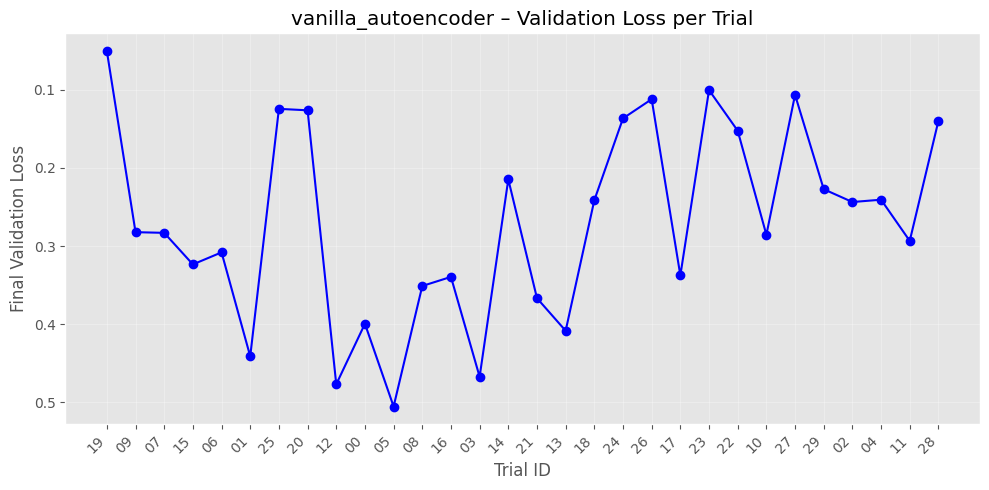

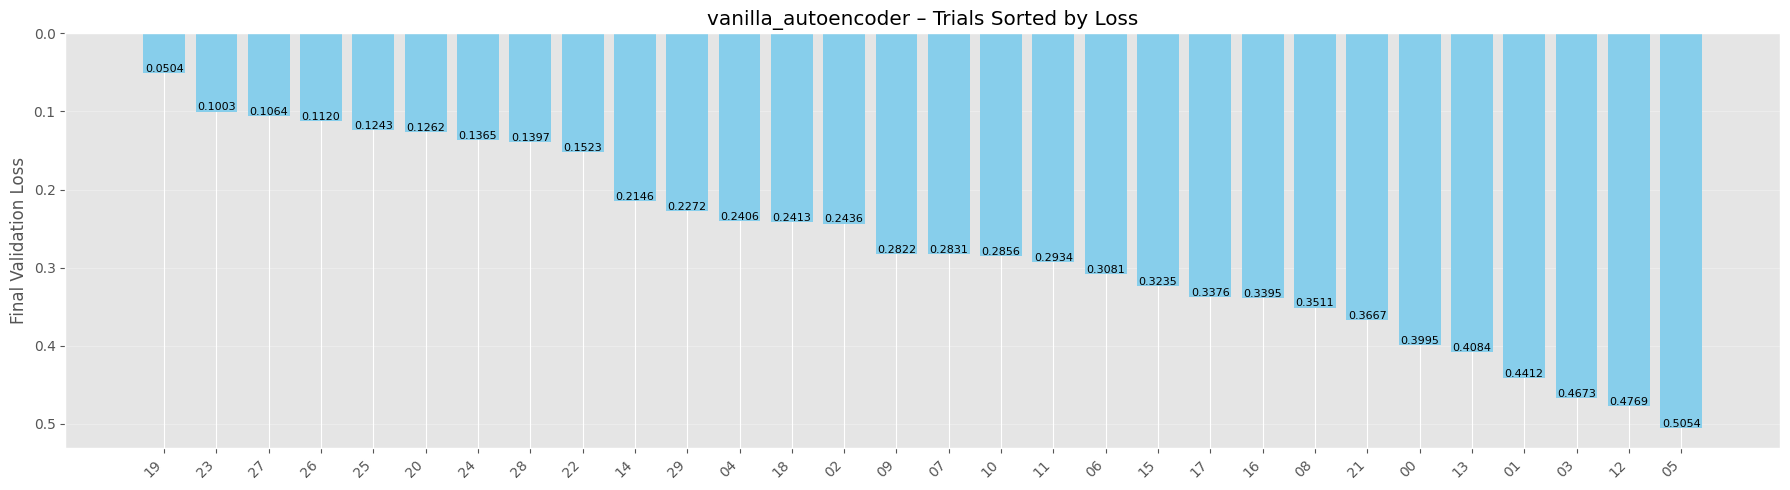

Loading trials for: lstm_autoencoder
Reloading Tuner from hp_search_logs/lstm_autoencoder/tuner0.json


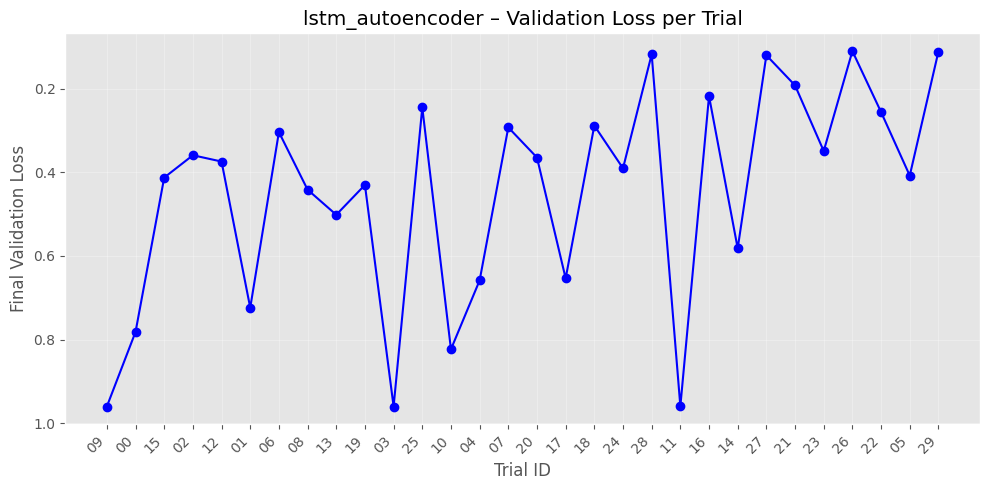

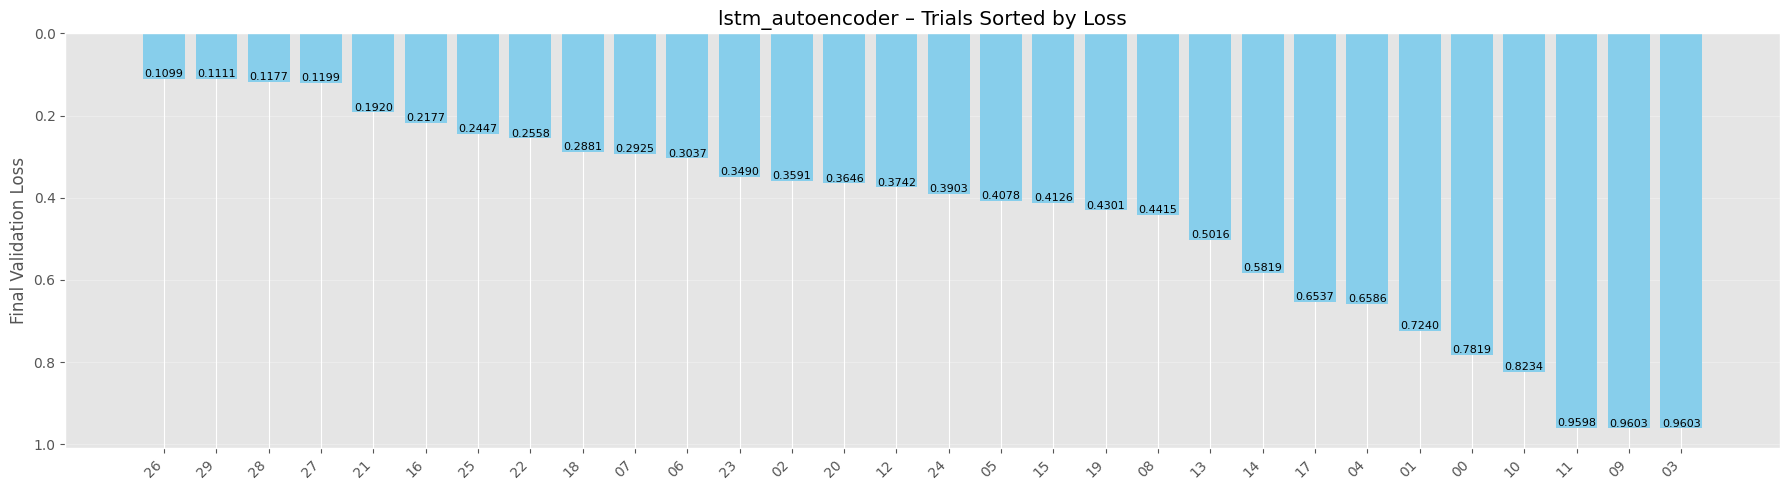

Loading trials for: transformer_autoencoder
Reloading Tuner from hp_search_logs/transformer_autoencoder/tuner0.json


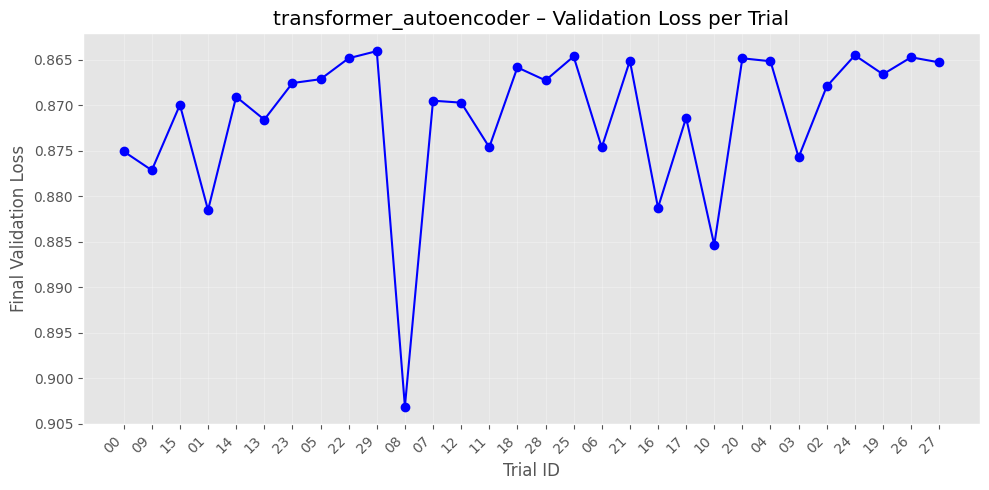

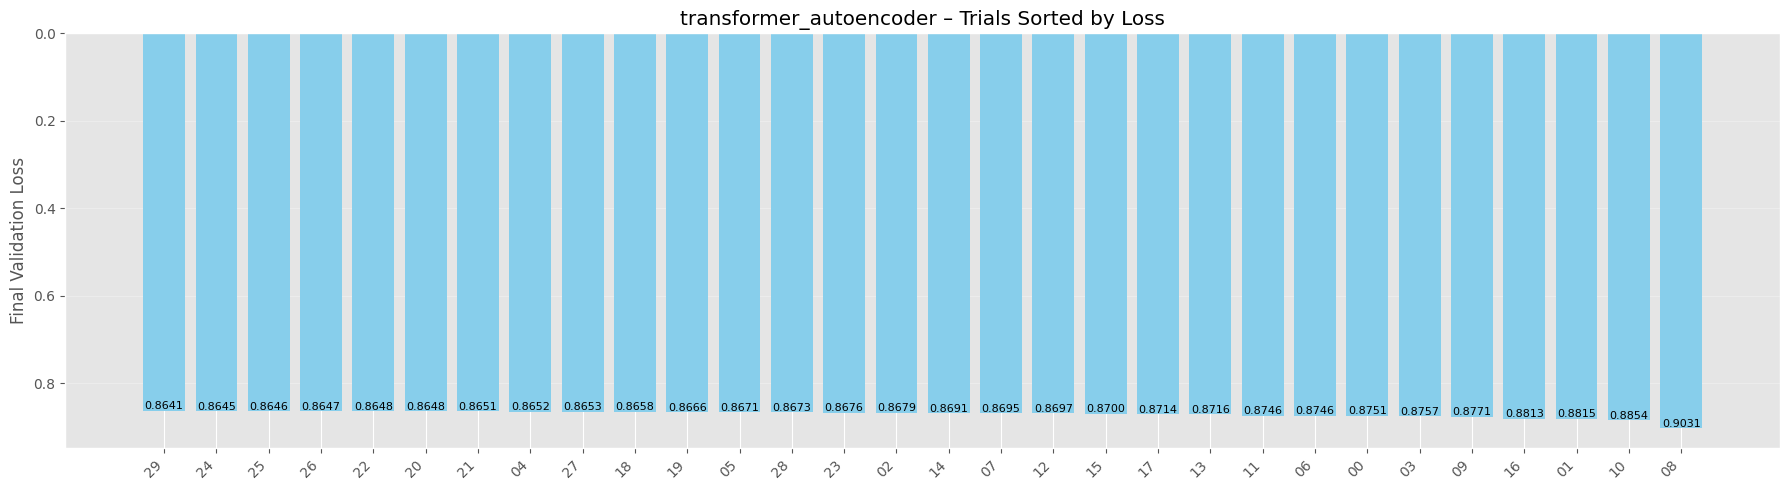

In [ ]:
for PROJECT in PROJECTS:
    LOGDIR = os.path.join(LOGDIR_ROOT, PROJECT)
    print(f"Loading trials for: {PROJECT}")

    tuner = BayesianOptimization(
        hypermodel=lambda hp: None,
        objective='val_loss',
        max_trials=1,
        directory=LOGDIR_ROOT,
        project_name=PROJECT
    )

    trials = list(tuner.oracle.trials.values())
    val_losses = []
    trial_ids = []

    for trial in trials:
        history = trial.metrics.get_history('val_loss')
        val = extract_final_val_loss(history)
        if val is not None:
            val_losses.append(val)
            trial_ids.append(trial.trial_id)

    if not val_losses:
        print(f"No valid val_loss found for {PROJECT}")
        continue

    plt.figure(figsize=(10, 5))
    plt.plot(trial_ids, val_losses, marker='o', linestyle='-', color='blue')
    plt.xlabel('Trial ID')
    plt.ylabel('Final Validation Loss')
    plt.title(f'{PROJECT} – Validation Loss per Trial')
    plt.xticks(rotation=45, ha='right')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    sorted_idx = np.argsort(val_losses)
    sorted_ids = [trial_ids[i] for i in sorted_idx]
    sorted_losses = [val_losses[i] for i in sorted_idx]

    plt.figure(figsize=(max(10, len(sorted_ids) * 0.6), 5))
    bars = plt.bar(range(len(sorted_ids)), sorted_losses, color='skyblue')
    plt.xticks(range(len(sorted_ids)), sorted_ids, rotation=45, ha='right')
    plt.ylabel('Final Validation Loss')
    plt.title(f'{PROJECT} – Trials Sorted by Loss')
    plt.gca().invert_yaxis()
    plt.grid(axis='y', alpha=0.3)

    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.001,
                 f"{height:.4f}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(rate)
        self.drop2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_out = self.att(inputs, inputs)
        attn_out = self.drop1(attn_out, training=training)
        out1 = self.norm1(inputs + attn_out)
        ffn_out = self.ffn(out1)
        ffn_out = self.drop2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

models = {}
models['Vanilla AE'] = load_model(
    'best_vanilla_autoencoder.h5',
    compile=False
)
models['LSTM AE'] = load_model(
    'best_lstm_autoencoder.h5',
    compile=False
)
models['Transformer AE'] = load_model(
    'best_transformer_autoencoder.h5',
    compile=False,
    custom_objects={'TransformerBlock': TransformerBlock}
)

for m in models.values():
    m.compile(optimizer='adam', loss='mse')

print("All models loaded and compiled successfully!")


All models loaded and compiled successfully!


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


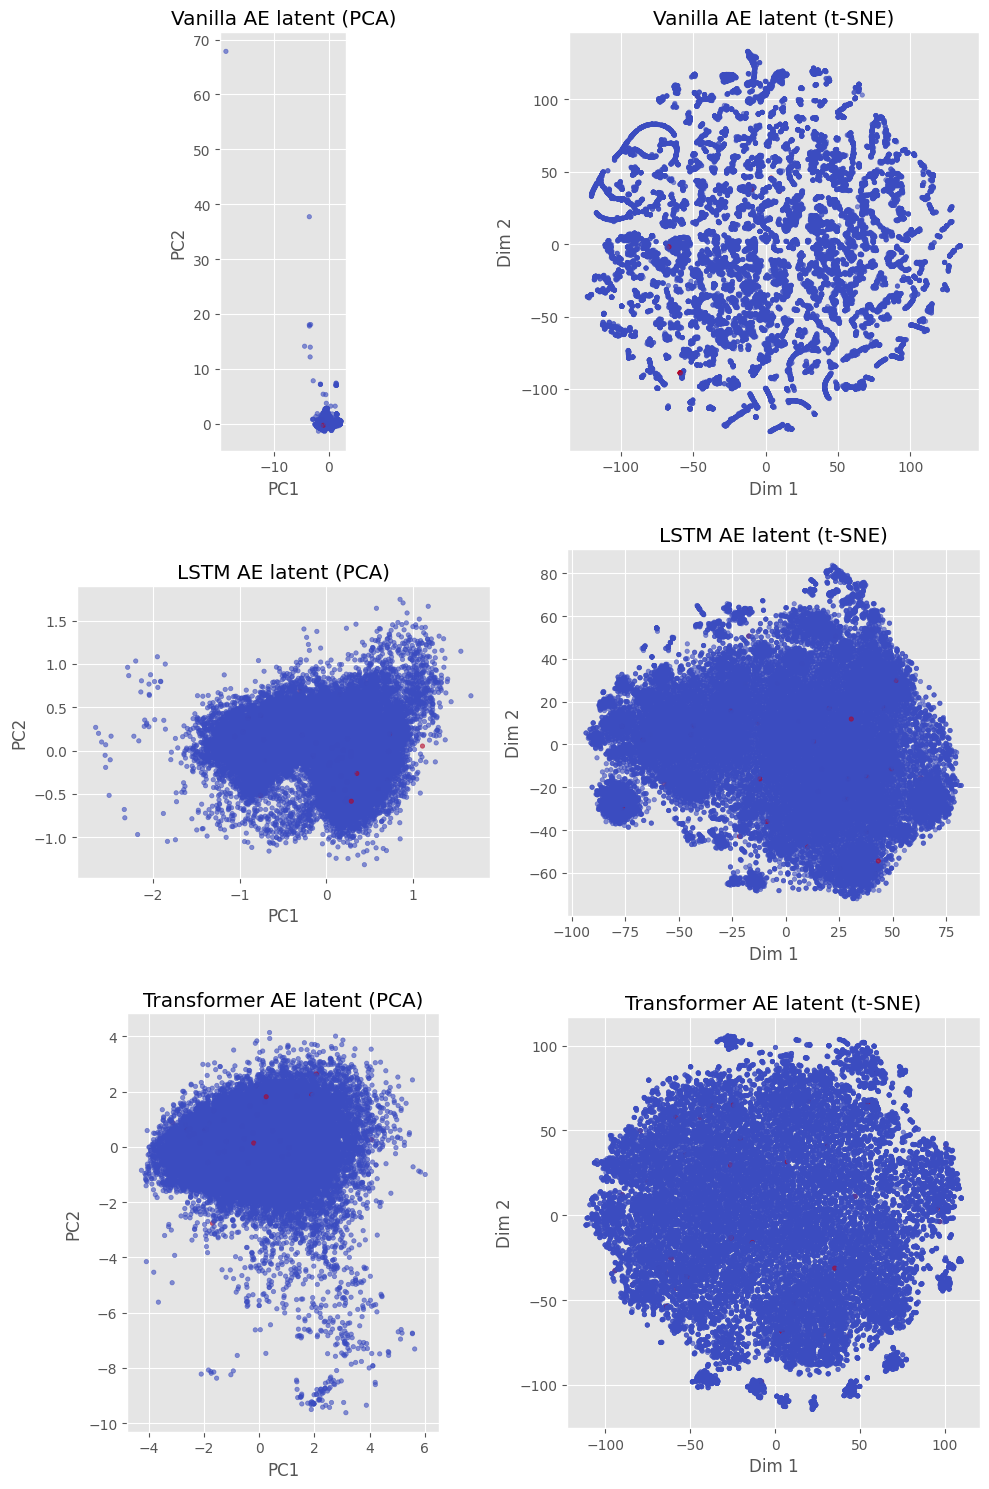

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = layers.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(rate)
        self.drop2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_out = self.att(inputs, inputs)
        attn_out = self.drop1(attn_out, training=training)
        out1 = self.norm1(inputs + attn_out)
        ffn_out = self.ffn(out1)
        ffn_out = self.drop2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

def create_sequences(data, seq_len=10):
    return np.stack([data[i:i+seq_len] for i in range(len(data)-seq_len+1)])

seq_len = 10
X_seq = create_sequences(X_test, seq_len)
y_seq = y_test[seq_len-1:]

models = {
    'Vanilla AE':     load_model('best_vanilla_autoencoder.h5', compile=False),
    'LSTM AE':        load_model('best_lstm_autoencoder.h5', compile=False),
    'Transformer AE': load_model(
                          'best_transformer_autoencoder.h5',
                          compile=False,
                          custom_objects={'TransformerBlock': TransformerBlock}
                      ),
}
for m in models.values():
    m.compile(optimizer='adam', loss='mse')

encoders = {}
for name, full_model in models.items():
    bottleneck = full_model.get_layer('bottleneck').output
    encoders[name] = Model(inputs=full_model.input, outputs=bottleneck)

latents = {}
labels  = {}

latents['Vanilla AE'] = encoders['Vanilla AE'].predict(X_test)
labels ['Vanilla AE'] = y_test

for name in ('LSTM AE', 'Transformer AE'):
    latents[name] = encoders[name].predict(X_seq)
    labels [name] = y_seq

fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(10, 15),
    subplot_kw={'aspect':'equal'}
)

for row, name in enumerate(models):
    Z = latents[name]
    lbl = labels[name]
    Z_pca = PCA(n_components=2).fit_transform(Z)
    Z_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(Z)

    ax = axes[row, 0]
    ax.scatter(
        Z_pca[:,0], Z_pca[:,1],
        c=lbl, cmap='coolwarm', alpha=0.6, s=10
    )
    ax.set_title(f'{name} latent (PCA)')
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')

    ax = axes[row, 1]
    ax.scatter(
        Z_tsne[:,0], Z_tsne[:,1],
        c=lbl, cmap='coolwarm', alpha=0.6, s=10
    )
    ax.set_title(f'{name} latent (t-SNE)')
    ax.set_xlabel('Dim 1'); ax.set_ylabel('Dim 2')

plt.tight_layout()
plt.show()


### Latent Space Analysis:

Latent Space Analysis assesses how effectively each autoencoder architruecture would differentiate the normal network flow from the anamolies. Visuals have been extracted for their 2-D latent embeddings using the methods both Principal Component Analysis (PCA) and the T-Distributed Stochastic Neighbor Embeddings (t-SNE). In these plots we have the blue colored dots representing the benign/regular traffic and the red points indicating the attacks or other anamalies. Each row in the above image corressponds to a different model, and we have PCA on the left, and t-SNE on the right.

1. Vanilla Autoencoder
- PCA: Almost all the points collapse into one tight blob area near the origin and we observe that the few red anomaly points lie as the extreme outliers.
- t-SNE plot: The plot is almost uniformly in a smear distributed similar to concentric cricles, with a few anomalies sprinkled across with no clear cluster separation.
- Interpretation: The vanilla auto encoder isn’t learning the rich representation of our web traffic, it is simply compressesing most of the inputs to almost the same code, and hence we observe that the anomalies don’t stand out well.

2. LSTM Autoencoder
- PCA: We notice that we see more of a spread along PC1 and PC2 principal components, this indicates that the network is capturing some temporal patterns in the flows. Additonally we observe that a handful of the red anamoly points are shifted towards the edges, but still many points overlap with regular traffic poitns.
- t-SNE: We observe the normal regular traffic is forming a dense cloud like representation, while there are some anomalous traffic points that are at the edge locations or in a few small side-clusters.
- Interpretation: The LSTM’s sequential modeling gives a better &richer latent space visualization where we have the anomalies being more distinct, but there is still a li.ttle non-trivial overlap.

3. Transformer Autoencoder
- PCA: We observe that the distribution fans out into a more broad, structured cloud and there are a few anomalies occupying the lower-density corners.
- t-SNE: We notice that the benign sample are clustering tightly at the center, while the anomalous points appear as distinct, isolated sections along the periphery of the regular traffic distribution.
- Interpretation: The self-attention mechanism of the transformers lets the model pick up very subtle, and long-range patterns in the incoming traffic. As a result, we have the normal and anomalous traffic existing in very different regions of latent space.

Overall, we notice that as we approach the better model interms of the architecture, the latent-space analysis visualization confirm that richer sequence aware architrecture enhance the separability of anamoalies in network traffic ebmeddings with the Transformer AutoEncoder giving us the best results.